### Sumário

- Simplificando o problema
- Backward Dynamic Programing (Top-down and Botton-up)
- Extraindo a política otima
- Calculando a função valor a partir de uma política

### Simplificando o problema

In [1]:
import numpy as np
import time
import cliff
import matplotlib.pyplot as plt
from IPython.display import clear_output

Neste seção vamos adicionar mais uma restrição ao nosso problema limitando o conjunto de ações possíveis que podem ser tomadas, essa restrição nos permitirá resolver a equação de Belman de forma exata sem a necessidade de fazer diversas iterações. 

Para o caso analisado vamos assumir que o agente só pode se move para direita e para baixo.

A = {"right", "down"}

Recapitulando o cenário do problema:

-------------------------------------------------
| P | 0 | 0 | 0 | 0 | * | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------------------
| * | * | * | 0 | 0 | * | 0 | 0 | * | * | 0 | 0 | 
-------------------------------------------------
| * | * | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------------------
| * | * | * | * | * | * | * | * | * | * | 0 | G | 
-------------------------------------------------


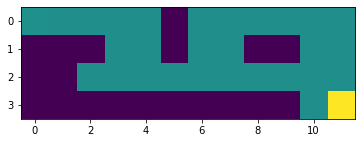

In [2]:
ROWS  = 4
COLS  = 12
START = (0, 0)
GOAL  = (3, 11)

OBSTACLE = [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3,8), (2, 1), (1, 1),
            (1, 0), (1, 2), (2, 0), (3, 0), (0, 5), (1, 8), (3, 9), (1, 9), (1, 5)]

cliff_game = cliff.Cliff(START, GOAL, ROWS, COLS, OBSTACLE)
cliff_game.show()


rewards = np.zeros((ROWS, COLS))
for i in range(0, ROWS):
    for j in range(0, COLS):
        rewards[i, j] = cliff_game.getReward((i,j))
        
plt.imshow(rewards/np.max(rewards))


### Backward Dynamic Programing (Top-down and Botton-up)

Como vemos na equação de Belman a função valor no instante $t$ dependo da função valor no instante $t+1$. 

$V_t(S_t) = max(R(S_t) + \gamma V_{t+1}(S_{t+1}))$

Como no nosso caso mudaremos de estado até o estado final onde chegamos no estado alvo (3, 11) e nesse estado não faremos mais transições terminando um episódio do jogo. Assim a função valor desse estado é conhecida e igual ao valor da recompensa.

$V((3 ,11)) = R((3, 11)) = 1000$

Graças a nova restrição adicionada so podemos chegar a esse estado vindo dos estados (2, 11) e (3, 10), desse modo podemos calcular a função desses estados e em seguidas dos estados acima e a esqueda desses até chegarmos no estado de partida (0,0).

Ou seja resolvemos o problema partindo do final e voltando para o inicio e assim calculando a função valor para cada estado.

Esse cálculo pode ser implementado de duas maneiras diferentes chamadas de Top-down e Botton-up).

- Top-down: Nesta abordagem começa-se calculando a função valor do estado inicial (0, 0) que dependo da função valor dos estados (1, 0) e (0, 1) que dependem de outros estados futuros até chegar no estado (3, 11) a qual conhecemos a função valor. Assim vamos calculando a função valor de forma recursiva até atingir o estado final e voltamos preenchendo o valor para os outros estados até chegar no estado inicial.


- Botton-up: Nesta abordagem inicia-se com o calculo da função do estado final (3 , 11), em seguida se calcula a função valor dos seus estados vizinhos até chegar ao estado inicial. Ou seja, vamos preenchendo a função valor do estado final para o inicial.

Veriquemos as duas implementações e as funções valor calculadas.

In [3]:
# Top-down solution
val_cached = dict()
def get_value(coord):
    if coord in val_cached:
        return val_cached[coord]
    
    coord_down = (coord[0]+1, coord[1])
    coord_right = (coord[0], coord[1]+1)
    
    # No more moves allowed, V(state) = Reward(s)
    if coord[0]+1 >= ROWS and coord[1]+1 >= COLS:
        val = rewards[coord[0], coord[1]]
    # Can only move right , V(state) = V(right) + Rewared(s)
    elif coord[0]+1 >= ROWS:
        val = get_value(coord_right) + rewards[coord[0], coord[1]]
    # Can only move down , V(state) = V(down) + Rewared(s)
    elif coord[1]+1 >= COLS:
        val = get_value(coord_down) + rewards[coord[0], coord[1]]
    # We can move down or right
    else:
        val_down  = get_value(coord_down)
        val_right = get_value(coord_right) 
        val = max(val_down, val_right) + rewards[coord[0], coord[1]]
    
    val_cached[coord] = val
    return val
        
def calculate_v_function_top_botton():
    get_value((0,0))
    return val_cached
    

In [4]:
# Botton-up solution
def calculate_v_function_botton_up():
    val_function = dict()
    
    for i in reversed(range(0, ROWS)):
        for j in reversed(range(0, COLS)):
            if i == ROWS-1 and j == COLS-1:
                # No more moves avaliable
                val_function[(i, j)] = rewards[i, j]
            elif i == ROWS-1:
                # We can only move right
                val_function[(i, j)] = val_function[(i, j+1)] + rewards[i, j]
            elif j == COLS-1:
                # We can only move down
                val_function[(i, j)] = val_function[(i+1, j)] + rewards[i, j]
            else:
                # We can move right and down
                val_function[(i, j)] = max(val_function[(i+1, j)], val_function[(i, j+1)]) + rewards[i, j]
    
    return val_function
    

In [5]:
def convert_vfunc_from_dict_to_arr(v_func_dict):
    # Convert dict value function to matriz format
    v_func_arr = np.zeros((ROWS, COLS))
    for ((i, j), val) in v_func_dict.items():
       v_func_arr[i, j] = val
    
    return v_func_arr

In [6]:
v_func_b_up = calculate_v_function_botton_up()
v_func_top_b = calculate_v_function_top_botton()

In [7]:
v_func_arr_b_up = convert_vfunc_from_dict_to_arr(v_func_b_up)
v_func_arr_top_b = convert_vfunc_from_dict_to_arr(v_func_top_b)

Text(0.5, 1.0, 'Value Function - Top Botton')

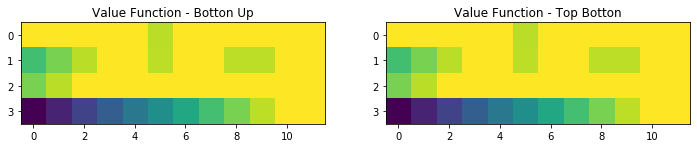

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(v_func_arr_b_up)
axs[0].set_title("Value Function - Botton Up")
axs[1].imshow(v_func_arr_top_b)
axs[1].set_title("Value Function - Top Botton")

Podemos ver que a função valor calculada por ambos os métodos apresentam os mesmos valores e que ela é mais negativa nos estados marcados por *. Esses valores são esperado pois navegar por esses estados adiciona recompensas negativas diminuindo o valor de estar nesse estado.

### Extraindo a política ótima

Vamos agora extrair a sequência ótima de estados que máximiza a acúmulo de recompensas como dado pela equação:

$ J(\pi(S)) = \Sigma_{0}^{T}\gamma^tR(S_t, a_\pi)$

Para calcular a sequência de estados, basta escolher como próximo estado aquele que satisfaz a equação:

$argmax_{S_{t+1}}{V(S_{t+1})}$


In [9]:
def get_next_state_given_v_func(state, v_func):
    state_right = (state[0], state[1]+1)
    state_down = (state[0]+1, state[1])
    
    # No more moves allowed
    if state[0]+1 >= ROWS and state[1]+1 >= COLS:
        return state
    elif state[0]+1 >= ROWS:
        state = state_right
        return state
    elif state[1]+1 >= COLS:
        state = state_down
        return state
        
    val_right = v_func[state_right]
    val_down = v_func[state_down]
    if val_down > val_right:
        state = state_down
    else:
        state = state_right
        
    return state
        

In [10]:
state = (0, 0)
path = [state]
while state != (ROWS-1, COLS-1):
    state = get_next_state_given_v_func(state, v_func_arr_top_b)
    path.append(state)

In [11]:
np.array(path).T

array([[ 0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3],
       [ 0,  1,  2,  3,  4,  4,  4,  5,  6,  7,  8,  9, 10, 11, 11]])

In [12]:
for state in path:
    cliff_game.setState(state)
    cliff_game.show()
    time.sleep(0.25)
    clear_output(True)


-------------------------------------------------
| S | 0 | 0 | 0 | 0 | * | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------------------
| * | * | * | 0 | 0 | * | 0 | 0 | * | * | 0 | 0 | 
-------------------------------------------------
| * | * | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------------------
| * | * | * | * | * | * | * | * | * | * | 0 | P | 
-------------------------------------------------


Text(0.5, 1.0, 'Optimal path highlight')

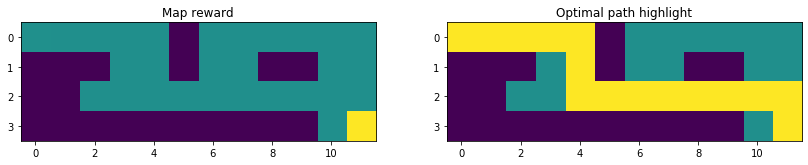

In [13]:
path_highlight = np.copy(rewards)
for state in path:
    path_highlight[state[0], state[1]] = 1000

fig, axs = plt.subplots(1, 2, figsize=(14, 18))
axs[0].imshow(rewards)
axs[0].set_title("Map reward")
axs[1].imshow(path_highlight)
axs[1].set_title("Optimal path highlight")

In [14]:
def extract_state_transition_matrix(val_function, get_next_state=None):
    # Extract policy transition matrix from value function
    policy_transition = np.zeros((ROWS*COLS, ROWS*COLS))
    
    for i in range(0, ROWS):
        for j in range(0, COLS):
            if i == ROWS-1 and j == COLS-1:
                continue
            next_state = get_next_state((i, j), val_function)
            policy_transition[i*COLS+j, next_state[0]*COLS+next_state[1]] = 1
    
    return policy_transition

Podemos ver a politica para todos os estados olhando a matriz transição de estado on cada linha corresponde ao estado original e cada coluna corresponde a estado seguinte. Os estados são colocados em um array de uma dimensão seguindo o mapeamento.

(i, j) -> i*COLS + j

Para a função valor calculada temos:

In [15]:
gamma = 1
state_transition = extract_state_transition_matrix(v_func_b_up, get_next_state_given_v_func)

Text(0.5, 1.0, 'State transition matrix of optimum policy')

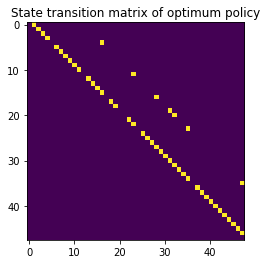

In [16]:
plt.imshow(state_transition)
plt.title("State transition matrix of optimum policy")

### Calculando a função valor a partir de uma política

Por fim, vamos fazer o processo inverso, primeiro vamos definir a politica representada através da matriz de transação de estados e calcular a função valor corresponte. No caso, a função valor pode ser calculada resolvendo um sistem N equações com N incognitas, onde N é número de estado do sistema (3*12 = 48).

$\bar{V_s} = \bar{R_{V_s}} + \gamma T .\bar{V_{s+1}}$

Onde T é a matriz de transação de estados definida pela política escolhida.

*Lembrando que cada política resultará em uma função valor diferente. 

Por exemplo, vamos primeiro calcular a função valor da política ótima e verificar se recuperamos a função valor calculada anteriormente.

In [17]:
gamma = 1
state_transition = extract_state_transition_matrix(v_func_top_b, get_next_state_given_v_func)
val = np.dot(np.linalg.pinv(np.eye(ROWS*COLS) - gamma*state_transition), np.reshape(rewards, (ROWS*COLS, 1)))

Text(0.5, 1.0, 'Value Function calculated from the optimum policy')

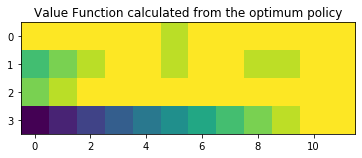

In [18]:
plt.imshow(val.reshape(ROWS, COLS))
plt.title("Value Function calculated from the optimum policy")

Agora vamos criar uma política na qual sempre nos mantemos no mesmo estado, nesse caso a função valor será igual a recompensa do sistema.

In [19]:
gamma = 0.999
state_transition = np.eye(ROWS*COLS)
val = np.dot(np.linalg.pinv(np.eye(ROWS*COLS) - gamma*state_transition), np.reshape(rewards, (ROWS*COLS, 1)))

Text(0.5, 1.0, 'Value function')

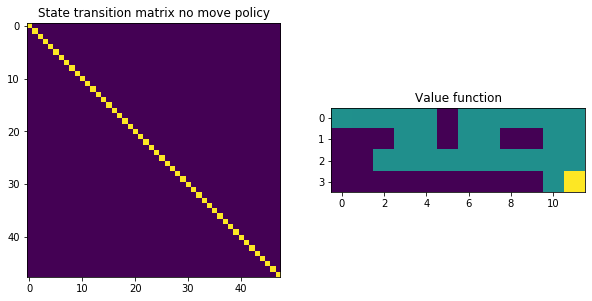

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(state_transition)
axs[0].set_title("State transition matrix no move policy")
axs[1].imshow(val.reshape(ROWS, COLS))
axs[1].set_title("Value function")